# Importing Libraries

In [8]:
import sys
import subprocess
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AlbertTokenizer
import shap
from lime.lime_text import LimeTextExplainer
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Loading SHAP and LIME Analysis Results

In [9]:
shap_df = pd.read_csv("./indicbert_explainability/shap_results_100")
lime_df = pd.read_csv("./indicbert_explainability/lime_results_100")
meta_df = pd.read_csv("./indicbert_explainability/explainability_results_100")  

# Selecting Predictions for Hate (correct and incorrect)

In [10]:
# Correct prediction (true_label == predicted_label == 1)
correct_hate_preds = meta_df[
    (meta_df["true_label"] == 1) & 
    (meta_df["predicted_label"] == 1)
]

if len(correct_hate_preds) > 0:
    correct_row = correct_hate_preds.sample(1).iloc[0]  # pick random
    print("Selected correct hate prediction sentence_id:", correct_row["sentence_id"])
else:
    print("No correct hate predictions found.")

Selected correct hate prediction sentence_id: 86


In [11]:
# Incorrect prediction (true_label == 1, predicted_label != 1)
incorrect_hate_preds = meta_df[
    (meta_df["true_label"] == 1) & 
    (meta_df["predicted_label"] != 1)
]

if len(incorrect_hate_preds) > 0:
    incorrect_row = incorrect_hate_preds.sample(1).iloc[0]  # pick random
    print("Selected incorrect hate prediction sentence_id:", incorrect_row["sentence_id"])
else:
    print("No incorrect hate predictions found.")


Selected incorrect hate prediction sentence_id: 33


In [12]:
sid_correct = correct_row.name
sid_incorrect = incorrect_row.name

shap_correct = shap_df[shap_df["sentence_id"] == sid_correct]
lime_correct = lime_df[lime_df["sentence_id"] == sid_correct]

shap_incorrect = shap_df[shap_df["sentence_id"] == sid_incorrect]
lime_incorrect = lime_df[lime_df["sentence_id"] == sid_incorrect]

# Plotting SHAP/LIME comparison plots for correct and incorrect predictions

In [13]:
# Loading Hindi font
font_path = "NotoSansDevanagari.ttf"  
fm.fontManager.addfont(font_path)
hindi_font = fm.FontProperties(fname=font_path)

# Reset global font for English / punctuation / emojis
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

/tmp/ipykernel_7189/3533392243.py:72: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipykernel_7189/3533392243.py:72: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipykernel_7189/3533392243.py:72: UserWarning: Glyph 129454 (\N{GUIDE DOG}) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129454 (\N{GUIDE DOG}) missing from font(s) Noto Sans Deva

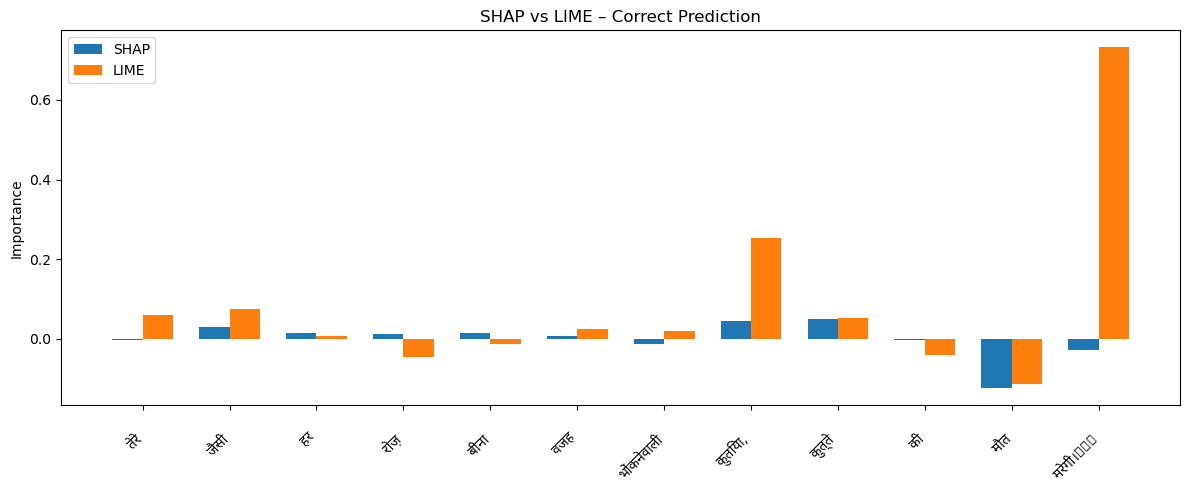

In [14]:
# Extract data for correct prediction
sid_correct = correct_row.name

shap_correct = shap_df[shap_df["sentence_id"] == sid_correct]
lime_correct = lime_df[lime_df["sentence_id"] == sid_correct]

tokens = shap_correct["token"].tolist()
shap_vals = shap_correct["value_shap"].tolist()
lime_vals = lime_correct["value_lime"].tolist()

x = np.arange(len(tokens))
width = 0.35

# Plot bars
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x - width/2, shap_vals, width, label="SHAP")
ax.bar(x + width/2, lime_vals, width, label="LIME")

# Set x-tick positions
ax.set_xticks(x)

# Assign labels with font fallback and spacing
new_labels = []
font_props = []

for token in tokens:
    if re.search('[\u0900-\u097F]', token):  # Hindi
        new_labels.append(token)
        font_props.append(hindi_font)
    else:  # English / punctuation / emoji
        new_labels.append(token)
        font_props.append(None)  # default font

ax.set_xticklabels(new_labels, rotation=45, ha='right')
# Apply fonts individually
for tick_label, prop in zip(ax.get_xticklabels(), font_props):
    if prop is not None:
        tick_label.set_fontproperties(prop)

ax.tick_params(axis='x', which='major', pad=15)  # push labels down

# Labels, title, legend
ax.set_ylabel("Importance")
ax.set_title("SHAP vs LIME – Correct Prediction")
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_7189/315639162.py:66: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipykernel_7189/315639162.py:66: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


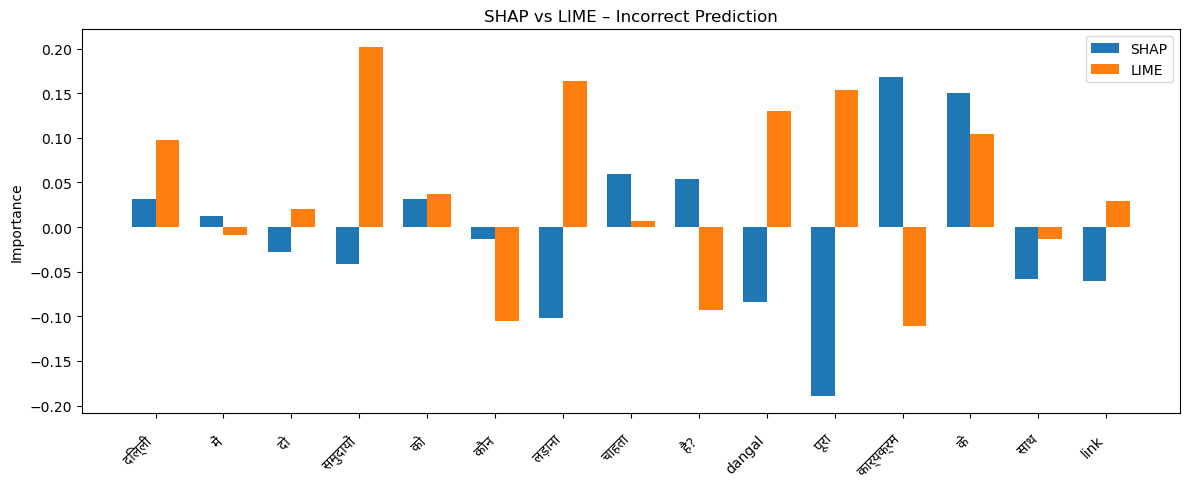

In [15]:

# Extract data for incorrect prediction
sid_incorrect = incorrect_row.name

shap_incorrect = shap_df[shap_df["sentence_id"] == sid_incorrect]
lime_incorrect = lime_df[lime_df["sentence_id"] == sid_incorrect]

tokens = shap_incorrect["token"].tolist()
shap_vals = shap_incorrect["value_shap"].tolist()
lime_vals = lime_incorrect["value_lime"].tolist()

x = np.arange(len(tokens))
width = 0.35

# Plot bars
fig, ax = plt.subplots(figsize=(12,5))

ax.bar(x - width/2, shap_vals, width, label="SHAP")
ax.bar(x + width/2, lime_vals, width, label="LIME")

# Hide default x-tick labels
ax.set_xticks(x)
ax.set_xticklabels([])  

# Add custom x-axis labels with proper font & position
y_offset = -0.05 
for i, token in enumerate(tokens):
    if re.search('[\u0900-\u097F]', token):  # Hindi token
        ax.text(i, y_offset, token, rotation=45,
                ha='right', va='top', fontproperties=hindi_font,
                transform=ax.get_xaxis_transform())
    else:  # English / punctuation / emojis
        ax.text(i, y_offset, token, rotation=45,
                ha='right', va='top', transform=ax.get_xaxis_transform())

# Labels, title, legend
ax.set_ylabel("Importance")
ax.set_title("SHAP vs LIME – Incorrect Prediction")
ax.legend()

plt.tight_layout()
plt.show()

# Plotting heatmap for most relevant tokens for correct hate prediction

In [390]:
def plot_correct_hate_heatmap(shap_df, meta_df, top_n_words=10, font_path="NotoSansDevanagari.ttf"):
    """
    Plots a word-level SHAP heatmap for correct hate predictions only.

    shap_df: DataFrame with ['sentence_id', 'token', 'value_shap']
    meta_df: DataFrame with ['true_label', 'predicted_label']
    top_n_words: Number of most important tokens to include
    font_path: path to Hindi font
    """
    # Filter for correct hate predictions
    correct_hate_ids = meta_df[(meta_df["true_label"] == 1) & (meta_df["predicted_label"] == 1)].index
    shap_correct_hate = shap_df[shap_df["sentence_id"].isin(correct_hate_ids)]
    
    # Find top tokens by average absolute importance
    token_means = shap_correct_hate.groupby('token')['value_shap'].apply(lambda x: np.mean(np.abs(x)))
    top_tokens = token_means.sort_values(ascending=False).head(top_n_words).index.tolist()
    
    # Filter dataframe for these tokens
    df_top = shap_correct_hate[shap_correct_hate['token'].isin(top_tokens)]
    
    # Pivot to sentences x tokens
    heatmap_df = df_top.pivot(index='sentence_id', columns='token', values='value_shap').fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(12, max(4, len(heatmap_df)//2)))
    sns.heatmap(heatmap_df, cmap="RdBu_r", center=0, annot=True, fmt=".2f", cbar_kws={'label':'SHAP Importance'})
    plt.xlabel("Token", fontproperties=hindi_font)
    plt.ylabel("Sentence ID")
    plt.title("Word-level SHAP Heatmap – Correct Hate Predictions")
    plt.xticks(rotation=45, ha='right', fontproperties=hindi_font)
    plt.tight_layout()
    plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib

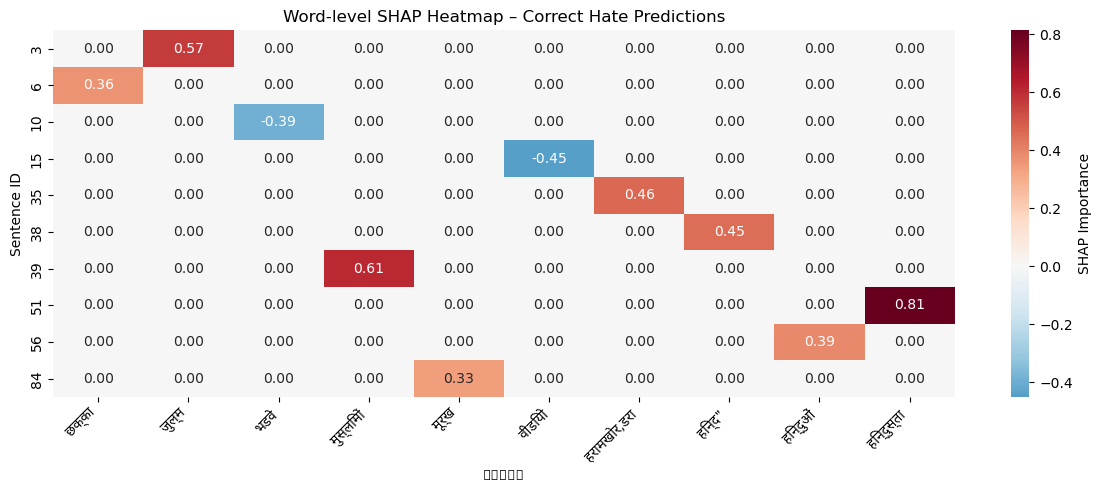

In [448]:
plot_correct_hate_heatmap(shap_df, meta_df, top_n_words=10)

# Plotting a heatmap of top k tokens 

In [483]:
def plot_avg_heatmap(df_shap, df_lime, top_k=40):

    # Clean tokens
    df_shap_clean = df_shap[df_shap["token"].notna() & df_shap["token"].str.strip().astype(bool)]
    df_lime_clean = df_lime[df_lime["token"].notna() & df_lime["token"].str.strip().astype(bool)]

    # Mean importance values
    shap_mean = df_shap_clean.groupby("token")["value_shap"].mean()
    lime_mean = df_lime_clean.groupby("token")["value_lime"].mean()

    # Merge only tokens common to both to avoids NaNs
    merged = (
        shap_mean.to_frame("shap")
        .join(lime_mean.to_frame("lime"), how="inner")
        .reset_index()
    )

    # Remove tokens that are all punctuation / weird symbols
    def is_meaningful(tok: str) -> bool:
        tok = tok.strip()
        if len(tok) == 0:
            return False
        # Keep only if Devanagari or Latin letters exist
        return bool(re.search(r'[A-Za-z\u0900-\u097F]', tok))

    merged = merged[merged["token"].apply(is_meaningful)]

    # Keep only top‑k highest importance tokens
    merged["max_abs"] = merged[["shap", "lime"]].abs().max(axis=1)
    merged = merged.sort_values("max_abs", ascending=False).head(top_k)

    tokens = merged["token"].tolist()
    data = np.vstack([merged["shap"].values, merged["lime"].values])

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(data, aspect="auto", cmap="coolwarm")

    ax.set_yticks([0, 1])
    ax.set_yticklabels(["SHAP", "LIME"])

    ax.set_xticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontproperties=hindi_font, fontsize=8)

    plt.colorbar(im)
    ax.set_title("Average token importance heatmap (SHAP vs LIME)")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19770/3115307139.py:58: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipykernel_19770/3115307139.py:58: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


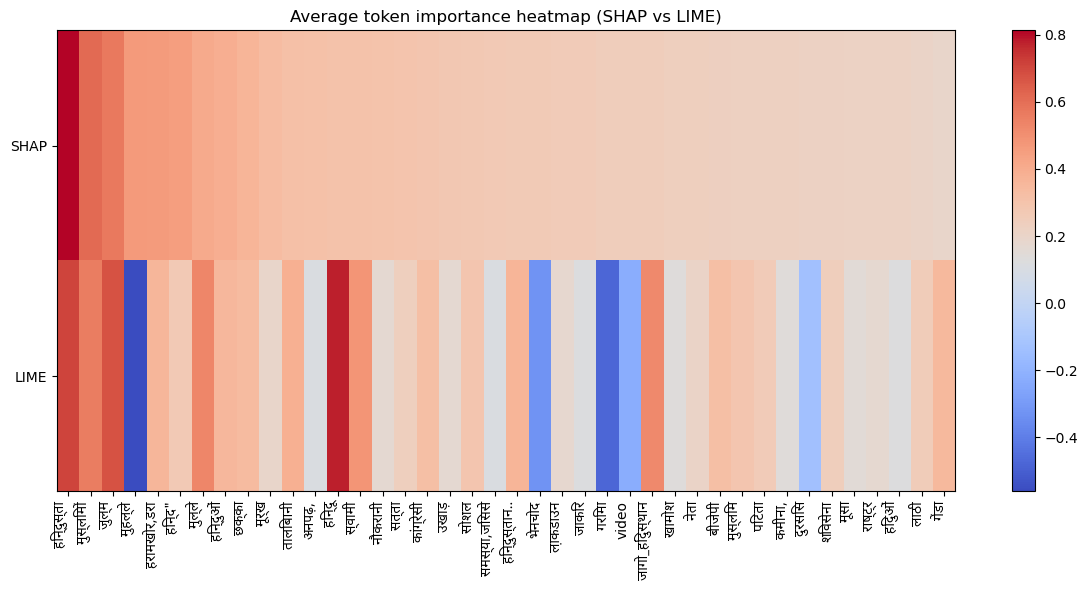

In [489]:
plot_token_heatmap(shap_df, lime_df, max_tokens=40)

# Plotting frequency vs average importance of tokens

In [16]:

def plot_freq_vs_importance(df_shap):
    # Load Hindi font
    font_path = "NotoSansDevanagari.ttf"
    if fm.findfont(fm.FontProperties(fname=font_path)):
        hindi_font = fm.FontProperties(fname=font_path)
    else:
        hindi_font = fm.FontProperties()

    # Clean tokens
    df = df_shap[df_shap["token"].notna() & df_shap["token"].str.strip().astype(bool)]

    # Frequency of each token
    freq = df.groupby("token").size().rename("freq")

    # Mean SHAP value
    shap_mean = df.groupby("token")["value_shap"].mean().rename("shap_mean")

    # Merge
    merged = pd.concat([freq, shap_mean], axis=1).reset_index()

    # Eliminate non-sensical tokens
    def meaningful(tok):
        return bool(re.search(r'[A-Za-z\u0900-\u097F]', tok.strip()))
    merged = merged[merged["token"].apply(meaningful)]

    # Plot
    plt.figure(figsize=(10,6))
    plt.scatter(merged["freq"], merged["shap_mean"], alpha=0.6, color="tomato")

    # Label top 8 most influential tokens
    top_tokens = merged.reindex(merged["shap_mean"].abs().sort_values(ascending=False).index).head(8)

    for _, row in top_tokens.iterrows():
        plt.text(row["freq"], row["shap_mean"], row["token"],
                 fontproperties=hindi_font, fontsize=10)

    plt.xlabel("Token Frequency")
    plt.ylabel("Mean SHAP Importance")
    plt.title("Token Frequency vs SHAP Importance")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19770/3744120093.py:49: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipykernel_19770/3744120093.py:49: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


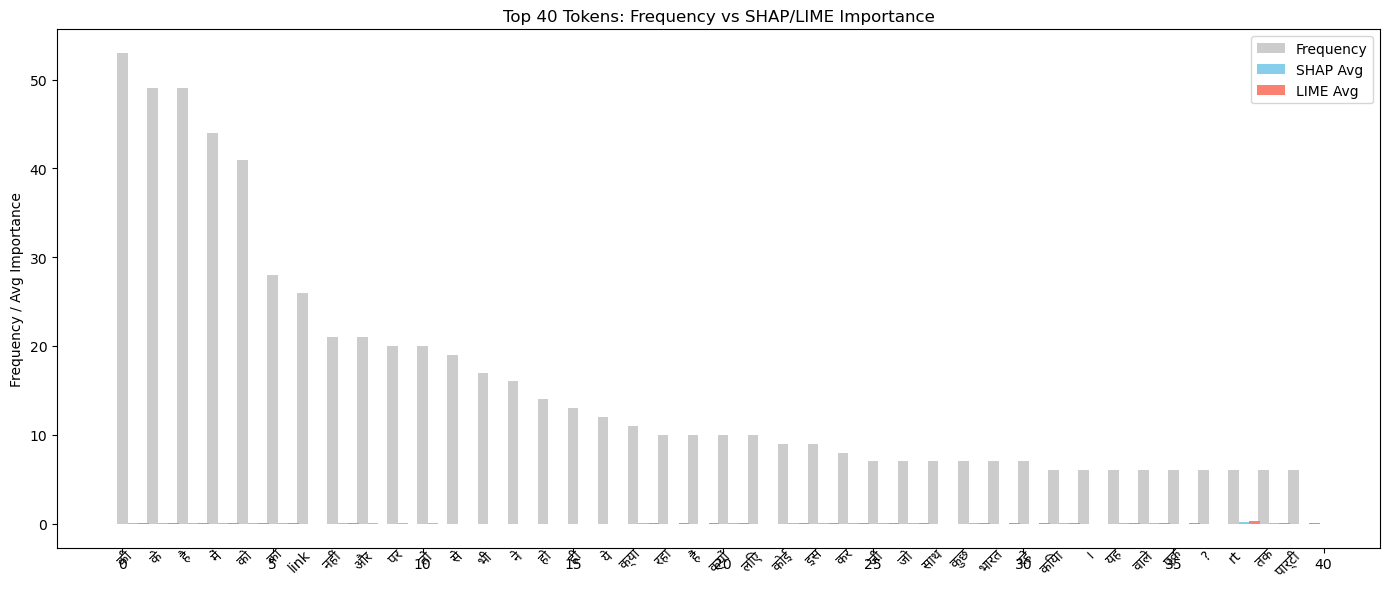

In [493]:
token_freq_vs_importance(shap_df, lime_df, top_n=40, title="Top 40 Tokens: Frequency vs SHAP/LIME Importance")